In [1]:
using JLD

push!(LOAD_PATH, ".")
using Util


function policy2name(tree_policy::ASCIIString)
    
    tps = eval(parse(replace(tree_policy, "anonymous function", "")))
    
    tpn = ""
    
    for tp in tps
        scale_str = ""
        if haskey(tp, "bScale") && tp["bScale"] == true
            scale_str = "s"
        end

        if tp["type"] == :UCB1
            if haskey(tp, "c")
                tpn = string(tp["type"]) * scale_str * "(" * string(tp["c"]) * ")"
            else
                tpn = string(tp["type"]) * scale_str
            end
        elseif tp["type"] == :TS || tp["type"] == :TSM
            tpn = string(tp["type"])
        elseif tp["type"] == :AUCB
            tpn = "A-UCB" * scale_str
        end
    end
    
    return tpn
end


function processDataByScenario(datafile::ASCIIString; datadir::ASCIIString = ".")
    
    D = load(joinpath(datadir, datafile));
    
    Scenarios = D["Scenarios"]
    TreePolicies = D["TreePolicies"]
    Results = D["Results"]
    
    R = Dict()
    
    for (key, results) in Results
        scenario, tree_policy = key
        returns = results["returns"]
        if !haskey(R, scenario)
            R[scenario] = Dict()
        end
        tpn = policy2name(tree_policy)
        R[scenario][tpn] = Dict()
        R[scenario][tpn]["mean"] = mean(returns)
        R[scenario][tpn]["std"] = std(returns)
    end

    for scenario in Scenarios
        R_ = R[scenario]
        println("Scenario: ", scenario)
        for tree_policy in TreePolicies[scenario]
            tpn = policy2name(tree_policy)
            println("  policy: ", @sprintf("%-34s", tpn), ", mean: ", @sprintf("%7s", neat(R_[tpn]["mean"])), ", std: ", @sprintf("%6.2f", neat(R_[tpn]["std"])))
        end
        println()
    end
end


function processDataByTreePolicy(n_list::Vector{Int64}; datadir::ASCIIString = ".")

    D = load(joinpath(datadir, "exp_" * string(n_list[1]) * ".jld"));
    TPN_list = map(policy2name, D["TreePolicies"][D["Scenarios"][1]])

    C = Dict()
    for tpn in TPN_list
        C[tpn] = Dict()
    end

    for n in n_list
        D = load(joinpath(datadir, "exp_" * string(n) * ".jld"));
        
        M = Dict()
        for (key, results) in D["Results"]
            scenario, _ = key
            returns = results["returns"]
            if !haskey(M, scenario)
                M[scenario] = Float64[]
            end
            push!(M[scenario], mean(returns))
        end
        
        Min = Dict()
        for scenario in keys(M)
            Min[scenario] = minimum(M[scenario])
            #println(scenario, " ", Min[scenario])
        end
        
        R = Dict()

        for (key, results) in D["Results"]
            scenario, tree_policy = key
            tpn = policy2name(tree_policy)

            if !haskey(R, tpn)
                R[tpn] = Float64[]
            end

            push!(R[tpn], mean(results["returns"]) / Min[scenario])
            #println(scenario, " ", tpn, " ", mean(results["returns"]) / Min[scenario])
        end
        
        for tpn in TPN_list
            C[tpn][n] = Dict()
            C[tpn][n]["mean"] = mean(R[tpn])
            C[tpn][n]["std"] = std(R[tpn])
            C[tpn][n]["N"] = length(R[tpn])
        end
    end

    return C
end

;

In [2]:
using PyPlot


function plotDataByTreePolicy(TPN_list::Vector{ASCIIString}, n_list::Vector{Int64}; datadir::ASCIIString = ".", bPlotErrorBar::Bool = true)

    color_list = ["b", "g", "r", "c", "m"]

    D = processDataByTreePolicy(n_list, datadir = datadir)

    i = 1
    for tpn in TPN_list
        X = Float64[]
        E = Float64[]

        for n in n_list
            push!(X, D[tpn][n]["mean"])
            # 95% confidence interval
            push!(E, 1.96 * D[tpn][n]["std"] / sqrt(D[tpn][n]["N"]))
        end

        semilogx(n_list, X, "x-" * color_list[i], label = tpn)
        if bPlotErrorBar
            errorbar(n_list, X, yerr = E, fmt = "x", ecolor = color_list[i])
        end

        i += 1
    end

    xlim(round(Int64, 0.5 * n_list[1]), round(Int64, 2 * n_list[end]))
    xlabel("Number of iterations")
    ylabel("Relative error")
    legend(loc = "best")
end


function saveData(TPN_list::Vector{ASCIIString}, n_list::Vector{Int64}; datadir::ASCIIString = ".")

    color_list = ["b", "g", "r", "c", "m"]

    D = processDataByTreePolicy(n_list, datadir = datadir)

    f = open("data.txt", "w")
    
    i = 1
    for tpn in TPN_list
        X = Float64[]
        E = Float64[]

        for n in n_list
            push!(X, D[tpn][n]["mean"])
            # 95% confidence interval
            push!(E, 1.96 * D[tpn][n]["std"] / sqrt(D[tpn][n]["N"]))
        end
        
        if i == 1
            write(f, "n ")
            writedlm(f, n_list', " ")
        end
        write(f, "re" * string(i) * " ")
        writedlm(f, X', " ")
        write(f, "err" * string(i) * " ")
        writedlm(f, E', " ")

        i += 1
    end

    close(f)
end

;

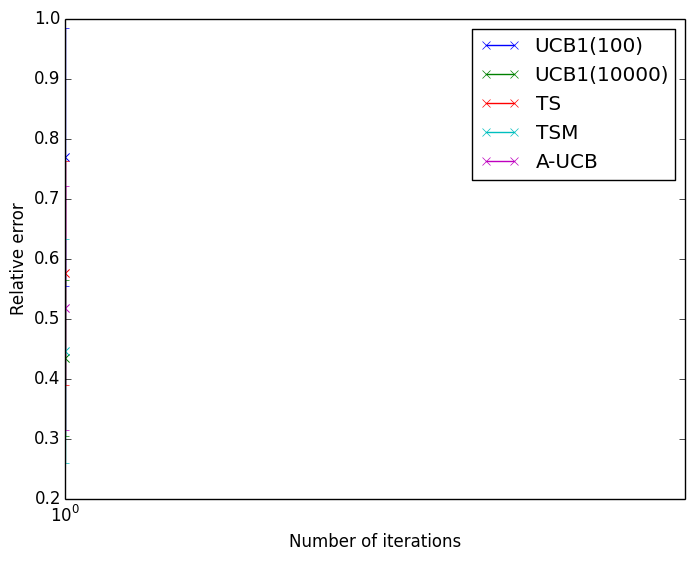

In [3]:
plotDataByTreePolicy(["UCB1(100)", "UCB1(10000)", "TS", "TSM", "A-UCB"], [1], datadir = "data_ijcai");

In [4]:
saveData(["UCB1(100)", "UCB1(10000)", "TS", "TSM", "A-UCB"], [1], datadir = "data_ijcai");